In [1]:
library(nlme)
library(ggplot2)
library(repr)

In [2]:
# See: https://stats.idre.ucla.edu/r/examples/alda/r-applied-longitudinal-data-analysis-ch-4/

alcohol1 <- read.table("https://stats.idre.ucla.edu/stat/r/examples/alda/data/alcohol1_pp.txt", 
                       header=T, sep=",")

In [3]:
head(alcohol1)

id,age,coa,male,age_14,alcuse,peer,cpeer,ccoa
1,14,1,0,0,1.732051,1.2649111,0.2469111,0.549
1,15,1,0,1,2.000000,1.2649111,0.2469111,0.549
1,16,1,0,2,2.000000,1.2649111,0.2469111,0.549
2,14,1,1,0,0.000000,0.8944272,-0.1235728,0.549
2,15,1,1,1,0.000000,0.8944272,-0.1235728,0.549
2,16,1,1,2,1.000000,0.8944272,-0.1235728,0.549


`age_14` is time in years from baseline.

I'm going to make some covariate values missing for demonstration purposes.

In [4]:
alcohol1$cpeer[3] <- NA
alcohol1$alcuse[5] <- NA

In [5]:
model.g <- lme(alcuse ~ ccoa+cpeer*age_14 , data=alcohol1, random= ~ age_14 | id, 
               na.action=na.exclude)
summary(model.g)

Linear mixed-effects model fit by REML
 Data: alcohol1 
       AIC      BIC    logLik
  617.7737 649.0619 -299.8869

Random effects:
 Formula: ~age_14 | id
 Structure: General positive-definite, Log-Cholesky parametrization
            StdDev    Corr  
(Intercept) 0.5010023 (Intr)
age_14      0.3837755 -0.043
Residual    0.5839571       

Fixed effects: alcuse ~ ccoa + cpeer * age_14 
                  Value  Std.Error  DF   t-value p-value
(Intercept)   0.6543866 0.08085294 160  8.093541  0.0000
ccoa          0.5788530 0.14841304  79  3.900284  0.0002
cpeer         0.6935007 0.11266775  79  6.155273  0.0000
age_14        0.2712194 0.06248350 160  4.340655  0.0000
cpeer:age_14 -0.1510785 0.08590963 160 -1.758575  0.0806
 Correlation: 
             (Intr) ccoa   cpeer  age_14
ccoa          0.001                     
cpeer         0.000 -0.147              
age_14       -0.434  0.002 -0.001       
cpeer:age_14 -0.001  0.001 -0.429  0.003

Standardized Within-Group Residuals:
        Min 

In [6]:
table(alcohol1$age_14)


 0  1  2 
82 82 82 

# Plotting population-level effects

I'd like to visualize the population-level ("fixed") effects over time (`age_14`) at various covariate values. The variables `cpeer` and `ccoa` only take on certain discrete values. I'd like to visualize the effects for individuals with `cpeer = 0.7708544` and at each of the two possible values for `ccoa`. Since everyone in this data set has a follow-up of 2 years, I'll visualize the effects over two years. (Generally, it makes sense to use mean duration of follow-up to select the time interval over which to visualize.)

To do this, I need to create a fake data set. Each fake individual will have a fake ID (i.e., an ID not included in the original data set). There will be two data points for each fake ID: one with `age_14=0` (i.e., baseline) and another with `age_14=2` (i.e., last time point I want to visualize). Then I need to pick values for my covariates.

In [7]:
# expand.grid will create a data set with all possible combinations of the inputs
# this is the fake data set I will use for visualization
newdata <- expand.grid(age_14=c(0,2),
                       cpeer=0.7708544,
                       ccoa=unique(alcohol1$ccoa))

In [8]:
newdata

age_14,cpeer,ccoa
0,0.7708544,0.549
2,0.7708544,0.549
0,0.7708544,-0.451
2,0.7708544,-0.451


In [9]:
# I need to manually assign fake IDs
# Since I know the structure of my fake data set (that each ID has two rows),
# I can do this easily by repeating each fake ID twice
# To make sure that ID's are fake, I'm going to start numbering from the maximum ID in the original data set
newdata$id <- rep(1:(nrow(newdata)/2), each=2) + max(alcohol1$id)

In [10]:
newdata

age_14,cpeer,ccoa,id
0,0.7708544,0.549,83
2,0.7708544,0.549,83
0,0.7708544,-0.451,84
2,0.7708544,-0.451,84


In [11]:
newdata$alcuse_pred0 <- predict(model.g, newdata = newdata, level = 0)
# including `level=0` as an argument for predict means that we are not going to bring
# in random effects for prediction (we cannot, anyway, because the IDs we assigned to 
# the fake data points do not exist in the original data set)

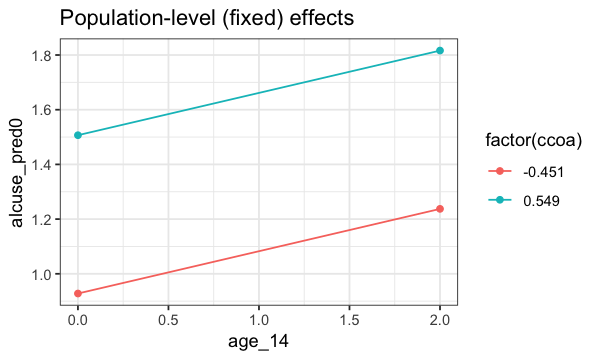

In [12]:
options(repr.plot.width=5, repr.plot.height=3)
p <- ggplot(newdata, aes(x=age_14, y=alcuse_pred0, group=id, color=factor(ccoa))) +
     geom_line() + geom_point() +
     theme_bw() + ggtitle("Population-level (fixed) effects")
p

# Plotting individual-level effects

In [13]:
# this prediction incorporates fixed + random effects
alcohol1$alcuse_pred <- predict(model.g)


# this prediction is based on fixed effects only
alcohol1$alcuse_pred0 <- predict(model.g, level=0)

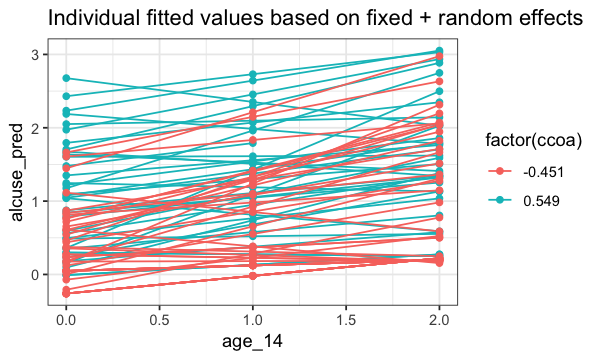

In [14]:
p <- ggplot(subset(alcohol1, !is.na(alcuse_pred)), 
            aes(x=age_14, y=alcuse_pred, group=id, color=factor(ccoa))) +
     geom_line() + geom_point() +
     theme_bw() + ggtitle("Individual fitted values based on fixed + random effects")
p

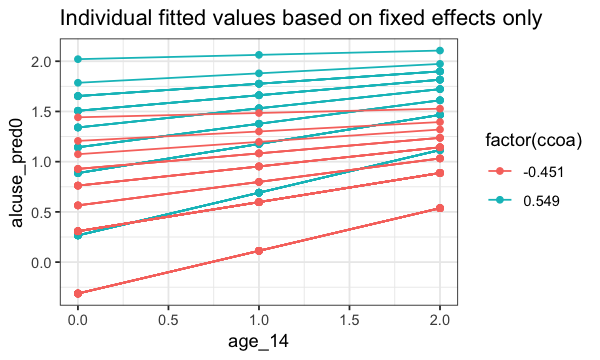

In [15]:
p <- ggplot(subset(alcohol1, !is.na(alcuse_pred0)), 
            aes(x=age_14, y=alcuse_pred0, group=id, color=factor(ccoa))) +
     geom_line() + geom_point() +
     theme_bw() + ggtitle("Individual fitted values based on fixed effects only")
p